# Imports

In [1]:
import csv
import re
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [2]:
TRAIN = '../data/interim/train.csv'
DEV   = '../data/interim/dev.csv'
TEST  = '../data/interim/test.csv'

# Functions

In [3]:
def loader(PATH):
    with open(PATH, mode ='r')as file:
        csvFile = csv.reader(file)
        text = []
        for lines in csvFile:
            text.append(lines)
    return text


def splitter(L):
    X = []
    y = []
    for i in L:
        X.append(i[0])
        y.append(int(i[1]))
        
    return X, y

# Load Data

In [4]:
train_data = loader(TRAIN) # Training
dev_data = loader(DEV)     # Validation
X_test = loader(TEST)      # Test

In [5]:
len(train_data), len(dev_data), len(X_test)

(100000, 10000, 10000)

In [6]:
train_data = train_data[0:1]
dev_data = dev_data[0:1]

In [7]:
train_data[0]

['Gotta listen to this! So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!',
 '1']

# Tokenize

In [8]:
def tokenizer(sentence):
    """Function to find all tokens in a given sentence
    """
    tok = re.compile('[\'\"]|[A-Za-z]+|[.?!:\'\"]+')
    
    return tok.findall(sentence)

In [9]:
X_train, y_train = splitter(train_data)
X_dev, y_dev = splitter(dev_data)

In [10]:
# hand-made tokenization
print(tokenizer(X_train[0]))

['Gotta', 'listen', 'to', 'this', '!', 'So', 'creative', '!', 'Love', 'his', 'music', 'the', 'words', 'the', 'message', '!', 'Some', 'of', 'my', 'favorite', 'songs', 'on', 'this', 'CD', '.', 'I', 'should', 'have', 'bought', 'it', 'years', 'ago', '!']


In [11]:
X_train_tokens = []
for sentence in X_train:
    temp = tokenizer(sentence)
    if len(temp) > 0:
        if len(temp) > 500:
            X_train_tokens.append(temp[0:500])
        else: X_train_tokens.append(temp)
    else: X_train_tokens.append('NULL')
print(len(X_train_tokens))

1


In [12]:
for x in X_train_tokens:
    if len(x) == 0 or len(x) > 500:
        print(x)

In [13]:
for i in X_train_tokens:
    if i == []:
        print('!!!')

In [14]:
X_dev_tokens = []
for sentence in X_dev:
    X_dev_tokens.append(tokenizer(sentence))
print(len(X_dev_tokens))

1


In [15]:
X_test[0], X_train[0]

(['ok ok'],
 'Gotta listen to this! So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!')

In [16]:
X_test_tokens = []
for sentence in X_test:
    X_test_tokens.append(tokenizer(str(sentence)))
print(len(X_test_tokens))

10000


# Check for GPU

In [17]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2060 with Max-Q Design


In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [19]:
# Encode our concatenated data
encoded_ = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train_tokens]

In [20]:
l = 0
for sent in encoded_:
    if len(sent) > l:
        l = len(sent)
        
print(l)

35


In [21]:
# Specify `MAX_LEN`
MAX_LEN = l

# Print sentence 0 and its encoded token ids
token_ids = preprocessing_for_bert(X_train[0:2])
print('Original: ', X_train[0])
print('Token IDs: ', token_ids[0])


# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_dev)
print('F\'ing Done!!')

Original:  Gotta listen to this! So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!
Token IDs:  tensor([[  101, 10657,  4952,  2000,  2023,   999,  2061,  5541,   999,  2293,
          2010,  2189,  1011,  1996,  2616,  1010,  1996,  4471,   999,  2070,
          1997,  2026,  5440,  2774,  2006,  2023,  3729,  1012,  1045,  2323,
          2031,  4149,  2009,  2086,   102]])
Tokenizing data...
F'ing Done!!


In [22]:
len(train_inputs), len(train_masks), len(val_inputs), len(val_masks)

(1, 1, 1, 1)

In [23]:
train_inputs

tensor([[  101, 10657,  4952,  2000,  2023,   999,  2061,  5541,   999,  2293,
          2010,  2189,  1011,  1996,  2616,  1010,  1996,  4471,   999,  2070,
          1997,  2026,  5440,  2774,  2006,  2023,  3729,  1012,  1045,  2323,
          2031,  4149,  2009,  2086,   102]])

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_dev)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Train Model

In [25]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size, num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 34.5 ms, sys: 0 ns, total: 34.5 ms
Wall time: 32.4 ms


# Optimizer

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

2022-03-22 13:26:39.237077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 13:26:39.237121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [27]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

# Start Training

In [28]:
%%time
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/xanadoo/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be re

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    0    |   0.573143   |     -      |     -     |   0.57   
----------------------------------------------------------------------
   1    |    -    |   0.573143   |  0.505445  |  100.00   |   0.66   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    0    |   0.465387   |     -      |     -     |   0.36   
----------------------------------------------------------------------
   2    |    -    |   0.465387   |  0.458745  |  100.00   |   0.56   
----------------------------------------------------------------------


Training complete!
CPU times: user 4.12 s, sys: 1.33 s, total: 5.45 s
Wall time: 7.78 s


In [29]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_tokens)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [30]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [31]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [32]:
%%time
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 56.8 ms


In [33]:
# Get predictions from the probabilities
threshold = 0.63
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of reviews predicted positive: ", preds.sum())

print(f'Accuracy: {round(100 * sum(preds==y_dev)/len(y_dev), 2)}%')

Number of reviews predicted positive:  1
Accuracy: 100.0%


AUC: nan
Accuracy: 100.00%


/home/xanadoo/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


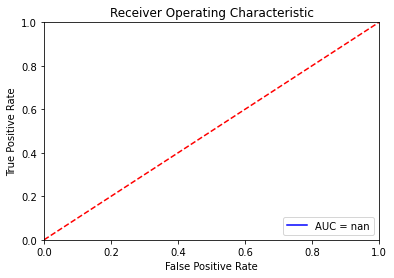

In [34]:
# Evaluate the Bert classifier
evaluate_roc(probs, y_dev)

In [35]:
%%time
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

CPU times: user 1min 6s, sys: 1.4 s, total: 1min 8s
Wall time: 1min 13s


In [36]:
# Get predictions from the probabilities
threshold = 0.63
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of reviews predicted positive: ", preds.sum())

Number of reviews predicted positive:  1112


In [37]:
preds

y_hat = []

for i in preds:
    if i:
        y_hat.append('positive')
    else: y_hat.append('negative')

y_hat[0:10]

['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative']

In [38]:
a= 5000
b= a + 20
[i for i in zip(y_hat[a:b], X_test[a:b])]

[('negative',
  ["He Ain't Heavy He's My Brother. Excellent Music CD, It was  number 1 hit in the UK, originally it was a fund raiser for the  family's of 96 Liverpool FC fans who died in a tragic stadium accident.  After 20 years the original court decision was reversed and the family's will get compensation from the British Government."]),
 ('negative', ['Five Stars Wonderful, soulful.']),
 ('negative', ['One Star Wrong selection']),
 ('negative',
  ["I am moved deeply every time I hear it as ... I am moved deeply every time I hear it as I remember it was the background music to Sullivan Ballou's letter to his wife Sarah."]),
 ('positive',
  ["Beautiful tribute to the Hillsborough victims The stars who lined up to make this single and the wonderful remake of a classic song makes this tune a must have in your collection. It's going to make a classic another memorable treasure."]),
 ('negative',
  ["A good tune for a good cause This all-star recording is very faithful to the Hollies' h

In [39]:
import pandas as pd

In [40]:
test_pred = pd.read_json( '../data/raw/music_reviews_test_masked.json.gz', lines=True)

test_pred['sentiment'] = y_hat

test_pred.head(10)

,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,sentiment,id,style,vote,image
0,True,"10 24, 2017",A2HAJB8L9NVYTZ,B007Y1AMHE,ok,ok,1508803200,negative,0,NaN,NaN,NaN
1,True,"04 8, 2015",AD78RH9JWBDEU,B007Y1AMHE,Its awesome,love it,1428451200,negative,1,NaN,NaN,NaN
2,True,"03 3, 2015",A5UNQFT0JQ8B,B007Y1AMHE,"great, really good!",Five Stars,1425340800,negative,2,NaN,NaN,NaN
3,True,"05 31, 2014",A1NPTQTAYO51XW,B007Y1AMHE,"THANK THEE LORD FOR THIS YOUNG MAN WISDOM, I P...",LISTEN & FOLLOW!!!,1401494400,negative,3,NaN,NaN,NaN
4,True,"01 21, 2013",AZ7ON5N7DLC6Y,B007Y1BQ9M,Andy Gibson has a good Texas music sound that ...,Love it,1358726400,negative,4,{'Format:': ' MP3 Music'},NaN,NaN
5,True,"05 28, 2016",A3MRV7R21969GY,B007Y1AM1A,the music sucks only got it because it was free,free,1464393600,negative,5,{'Format:': ' MP3 Music'},NaN,NaN
6,True,"01 9, 2015",AZAW12EWF3O6G,B007Y1ANFA,Not interesting.,Nope,1420761600,negative,6,NaN,NaN,NaN
7,True,"04 22, 2017",A1S9270CMM2DYJ,B007Y1AO0E,I didn't like this music at all,One Star,1492819200,negative,7,NaN,NaN,NaN
8,True,"01 9, 2015",AZAW12EWF3O6G,B007Y1AO0E,Not interesting.,Walking Away from this Song,1420761600,negative,8,NaN,NaN,NaN
9,True,"05 3, 2013",A3TIUJY8QC52KP,B007Y1AO0E,See my previous review about this music. If th...,Music,1367539200,negative,9,NaN,NaN,NaN


In [41]:
test_pred.to_json('../data/predictions/music_reviews_test.json', orient='records')

In [42]:
!python3 --version

Python 3.8.10
